This notebook is based on the jupyter notebooks of Jake Vanderplas ([Density-GMM](https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/04.3-Density-GMM.ipynb), [Gaussian-Mixtures](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb) and [Kernel-Density-Estimation](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb)).<br>I fix some bugs and also add / remove some parts.

##### References:
- [sklearn - Gaussian mixture models](https://scikit-learn.org/stable/modules/mixture.html)
- [sklearn - Density Estimation](https://scikit-learn.org/stable/modules/density.html)
- [sklearn - Kernel Density](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html)
- [sklearn - Gaussian Mixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)
- [sklearn - Bayesian Gaussian Mixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html)

______________

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

Creating one-dimensional data in a normal distribution. As you can see below the density is a mixture of three normal distributions.

Datapoints: 2300


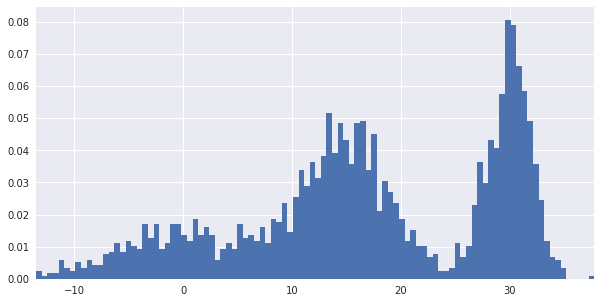

In [2]:
x = np.concatenate([np.random.normal(0,  6, 500),
                    np.random.normal(15, 4, 1000),
                    np.random.normal(30, 2, 800)])

print('Datapoints:',x.shape[0])

x_min = np.min(x)
x_max = np.max(x)

plt.figure(figsize=(10,5))
plt.hist(x, bins=100, density=True)
plt.xlim(x_min, x_max)
plt.show()

Plotting the data by a histogram and setting `density=True` will show the density of the distribution. This is the easiest way to inspect the data. One problem about this is the correct bin size `bins`. To show this, we can set it to `bins=10`

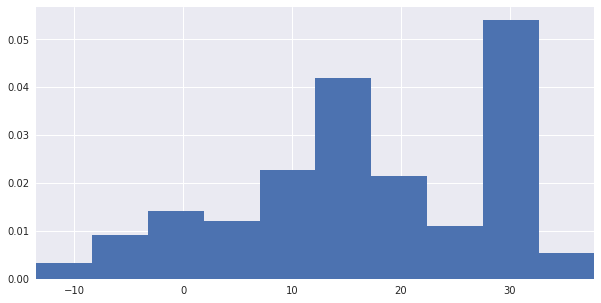

In [3]:
plt.figure(figsize=(10,5))
plt.hist(x, bins=10, density=True)
plt.xlim(x_min, x_max)
plt.show()

And also to `bins=100`

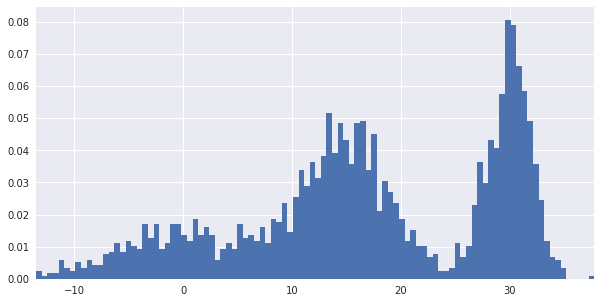

In [4]:
plt.figure(figsize=(10,5))
plt.hist(x, bins=100, density=True)
plt.xlim(x_min, x_max)
plt.show()

### Gaussian Mixture Model
With `Gaussian Mixture` we can approximate the density. If you remember we created the data with three normal distrbutions. Therefore it makes sense to set the parameter `n_components=3` to fit the data in a good way.

If you set `n_components` to 1 or 2 you will see how the approximation cant fit the data correctly.

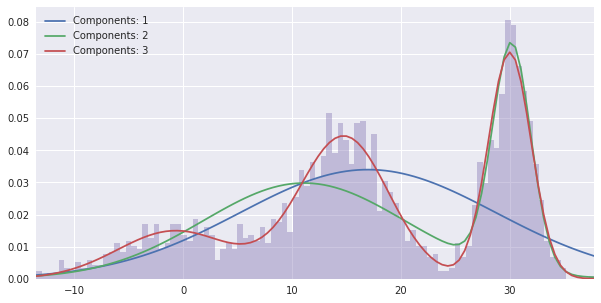

In [5]:
from sklearn.mixture import GaussianMixture

# Reshape data for fitting GM
X = np.reshape(x, [-1,1])

plt.figure(figsize=(10,5))

for i in range(1,4):
    gm = GaussianMixture(
        n_components=i,
    ).fit(X)
    # Generating 100 numbers in the specified interval
    x_interval = np.linspace(start=x_min, stop=x_max, num=100)
    x_interval = np.reshape(x_interval, [-1,1])
    density = np.exp(gm.score_samples(x_interval))
    plt.plot(x_interval, density, label='Components: %i'%(i))

plt.hist(x, bins=100, density=True, alpha=0.4)
plt.xlim(x_min, x_max)
plt.legend()
plt.show()

You can display the determined components. Gaussian mixture uses expectation–maximization.

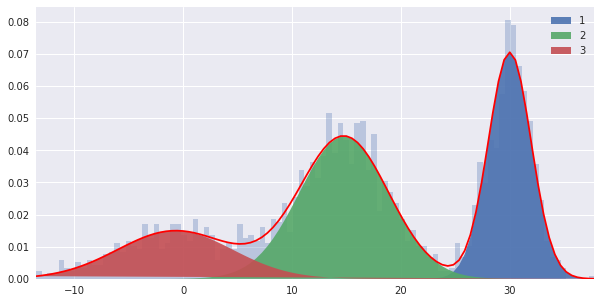

In [6]:
from scipy import stats

plt.figure(figsize=(10,5))
plt.hist(x, bins=100, density=True, alpha=0.3)
plt.plot(x_interval, density, '-r')

for i in range(gm.n_components):
    pdf = gm.weights_[i] * stats.norm(gm.means_[i, 0], np.sqrt(gm.covariances_[i, 0])).pdf(x_interval)
    plt.fill(x_interval, pdf, alpha=.9, label=i+1)
plt.legend()
plt.xlim(x_min, x_max)
plt.show()

### Calculating BIC / AIC to know how many Gaussians
As you may know from KMeans for clustering data, its cruccial to choose the right number of clusters. For Gaussian Mixture its the same for the number of mixture components `n_components`. The optimal number of `n_components` is the value that minimizes the AIC (Akaike information criterion) or BIC (Bayesian information criterion), depending on which approximation we wish to use.

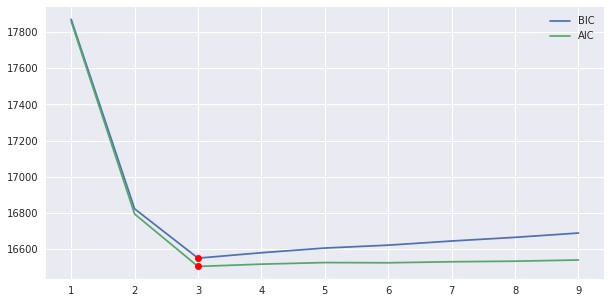

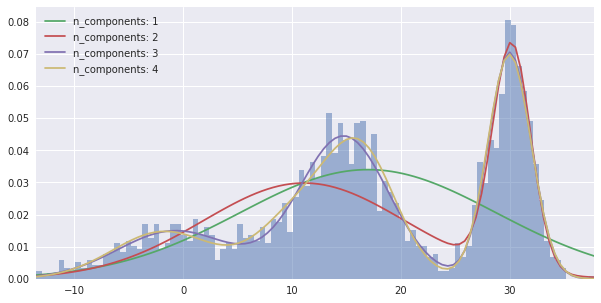

In [7]:
n_estimators = np.arange(1, 10)
clfs = [GaussianMixture(n_components=n).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

# Plotting AIC / BIC per component
plt.figure(figsize=(10,5))
plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.plot(np.argmin(bics)+1, np.min(bics),"ro")
plt.plot(np.argmin(aics)+1, np.min(aics),"ro")

plt.xticks(n_estimators)
plt.legend()
plt.show()

# Plotting approximation per component
plt.figure(figsize=(10,5))
plt.hist(x, bins=100, density=True, alpha=0.5)
for clf in clfs[0:4]:
    plt.plot(x_interval, np.exp(clf.score_samples(x_interval)), label='n_components: %i'%clf.get_params()['n_components'])
plt.xlim(x_min, x_max)
plt.legend()
plt.show()

As you can see in the plot above three components fits best. This makes sense as you remeber we created the data with three normal distributions.

### Outlier detection
You can use Gaussian Mixture also for detecting outliers in the data.

Creating 20 outlier

In [8]:
generate_samples = 20
true_outliers = np.sort(np.random.randint(0, len(x), generate_samples))
XX = X.copy()
XX[true_outliers] += np.reshape(np.array(50 * np.random.randn(generate_samples)), [-1,1])

#### Fitting data with outliers

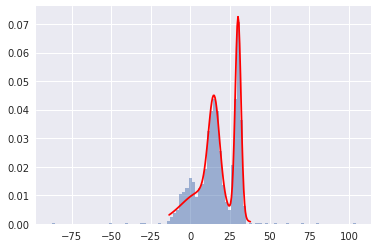

In [9]:
gm_outlier = GaussianMixture(3, max_iter=500, random_state=0)
gm_outlier.fit(XX)
x_interval = np.linspace(x_min, x_max, 100)

x_new = []
for v in x_interval:
    x_new.append(gm_outlier.score([[v]]))
density_noise = np.exp(x_new)

plt.hist(XX, 100, density=True, alpha=0.5)
plt.plot(x_interval, density_noise, '-r')
plt.show()

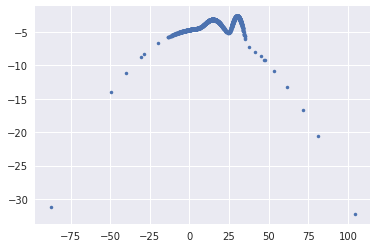

In [10]:
log_likelihood = gm_outlier.score_samples(XX)
plt.plot(XX, log_likelihood, '.')
plt.show()

In [11]:
threshold = -7

detected_outliers = np.where(log_likelihood < threshold)[0]
print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[ 196  250  282  347  366  550  633  676  688  742 1000 1132 1168 1337
 1407 1414 1514 1515 1913 1916]

detected outliers:
[ 250  282  366  550  633  676  688 1168 1337 1407 1502 1514 1515 1913
 1916]


In [12]:
print('Outliers not found:', set(true_outliers)-set(detected_outliers))

Outliers not found: {196, 1414, 742, 1000, 1132, 347}


In [13]:
print('Wrong detected outliers:', set(detected_outliers)-set(true_outliers))

Wrong detected outliers: {1502}


### Kernel Density Estimation
Another approach is Kernel Density Estimation (KDE) which is neighbor-based approach.

The bandwidth of the kernel is a hyperparameter which exhibits a strong influence on the resulting estimate.
KDE is a non-parametric way to estimate the probability density function of a random variable.

In [14]:
from sklearn.neighbors import KernelDensity

kde_01 = KernelDensity(bandwidth=0.05, kernel='gaussian').fit(X)
density_kde_01 = np.exp(kde_01.score_samples(x_interval[:, None]))

kde_02 = KernelDensity(bandwidth=10.0, kernel='gaussian').fit(X)
density_kde_02 = np.exp(kde_02.score_samples(x_interval[:, None]))

As you can see below the bandwith has a huge impact how the model is fitting the training data. Increasing bandwith results in a smoother curve but on the extreme side it will underfitting dramatically.

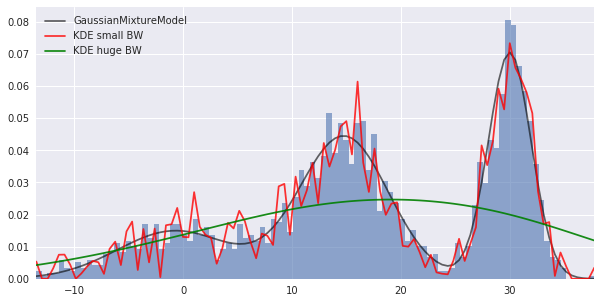

In [15]:
plt.figure(figsize=(10,5))
plt.hist(x, 100, density=True, alpha=0.6)
plt.plot(x_interval, density, 'black', label='GaussianMixtureModel', alpha=0.6)
plt.plot(x_interval, density_kde_01, 'red',   label='KDE small BW',  alpha=0.8)
plt.plot(x_interval, density_kde_02, 'green', label='KDE huge BW',   alpha=0.9)
plt.xlim(x_min, x_max)
plt.legend()
plt.show()